## Analyzing generated dataset

### Import data

In [1]:
import os
import sys
project_root = os.path.dirname(os.path.abspath(''))
sys.path.insert(0, project_root)
sys.path.insert(0, os.path.join(project_root, 'model'))
sys.path.insert(0, os.path.join(project_root, 'dataset_generation'))

from importlib import reload
import analysis_util
import util
reload(analysis_util)
reload(util)

from analysis_util import analyze_outliers, plot_value_distributions, analyze_sequences, analyze_syntax_tokens, plot_values
from data_util import load_dataset, create_dataloader, create_value_transform
from util import load_config
import pandas as pd
import numpy as np
import torch

In [2]:
from data_util import calc_priors_and_means, load_wandb_model, create_dataloader_from_wandb

model, cfg = load_wandb_model(run='om4vbk2m', name='last.ckpt', project='simexp-03', replace=True, fallback_cfg_path='../model/config.yaml')
train_loader, test_loader, info = create_dataloader_from_wandb(cfg)
priors, means = calc_priors_and_means(train_loader)

KeyboardInterrupt: 

In [3]:
priors

{'syntax_prior': np.float32(1.6957272),
 'consts_prior': np.float32(0.06632848),
 'values_prior': tensor(1.9573e-06)}

In [49]:
datapath = '/Users/luis/Desktop/Cranmer2024/Workplace/smallMutations/similar-expressions/data'
syntax, consts, values, val_x, syntax_cats = load_dataset(datapath, 'dataset_241127_2')

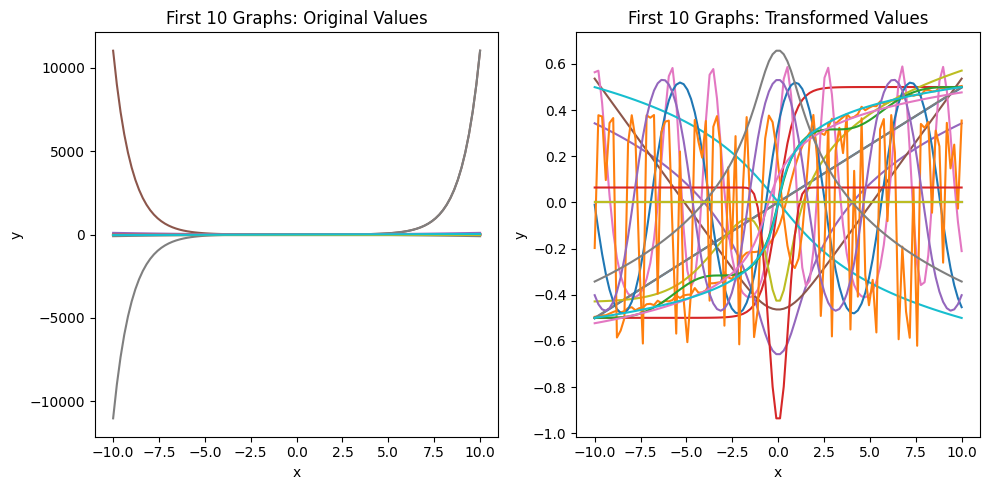

In [50]:
import data_util
reload(data_util)
from data_util import create_value_transform

cfg = load_config('../model/config.yaml', fallback_cfg_path='../model/config.yaml')
value_transform = create_value_transform(cfg.training.value_transform, torch.tensor(values))
val_transformed = value_transform(torch.tensor(values)).detach().numpy()

i = 0
plot_values(val_x, values, val_transformed, idx=np.arange(i, i+20))

In [69]:
transform_cfg = cfg.training.value_transform

mapping = {
    'arcsinh': lambda x: torch.arcsinh(x),
    None: lambda x: x
}[transform_cfg.mapping]

if transform_cfg.bias == 'dataset' or transform_cfg.scale in ['dataset-std', 'dataset-range']:
    values_mapped = mapping(values)
else:
    values_mapped = None

bias = {
    'dataset': lambda _: values_mapped.mean(),
    'sample': lambda x: x.mean(dim=1).unsqueeze(1),
    None: lambda _: 0
}[transform_cfg.bias]

def replace_with(values_mapped, value, replacement):
    values_mapped[values_mapped == value] = replacement # Dont change the scale if all values are the same
    return values_mapped

scale = {
    'dataset-std': lambda _: values_mapped.std().item(),
    'sample-std': lambda x: replace_with(x.std(dim=1), 0, 1).unsqueeze(1),
    'dataset-range': lambda _: (values_mapped.max() - values_mapped.min()).item(),
    'sample-range': lambda x: replace_with(x.max(dim=1)[0] - x.min(dim=1)[0], 0, 1).unsqueeze(1),
    None: lambda _: 1
}[transform_cfg.scale]

def combined_transform(x):
    x_mapped = mapping(x)
    x_scaled = x_mapped / scale(x_mapped)
    return x_scaled - bias(x_scaled)

In [83]:
np.where(np.abs(val_transformed.mean(axis=1)) > 1)[0]

array([ 101837,  120602,  189283,  344446,  361735,  665276,  695463,
        742463,  751865,  763234, 1016980, 1053097, 1144107, 1194562,
       1208216, 1264410, 1481696, 1516281, 1528493, 1637976, 1689896,
       2041735])

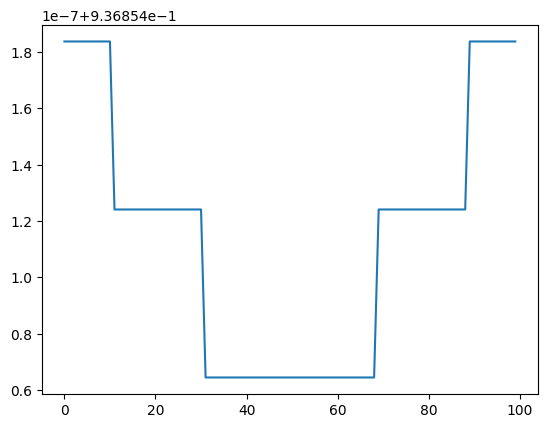

In [84]:
a = values[120602, :]
plt.plot(a)


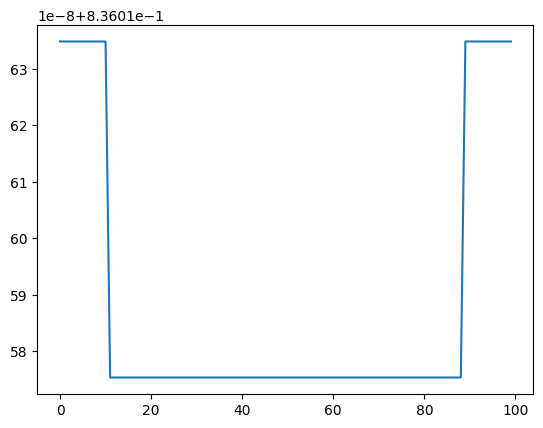

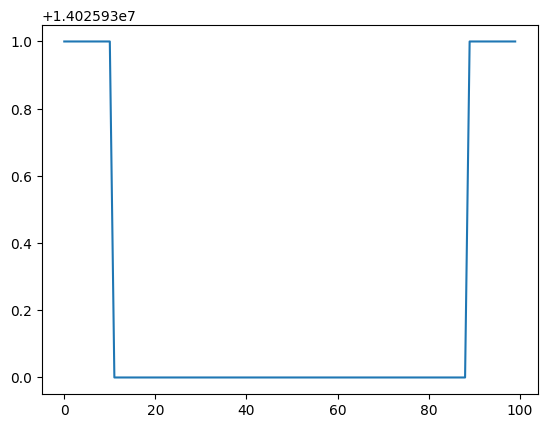

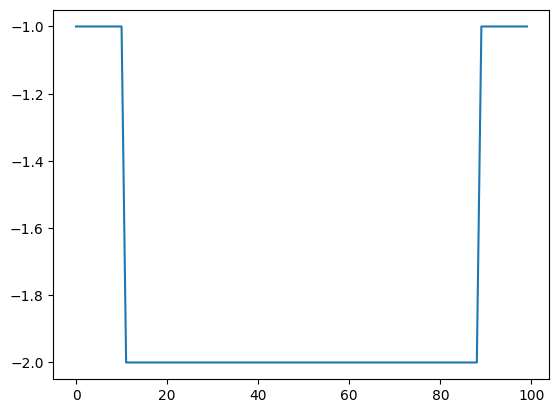

In [96]:
a_mapped = mapping(torch.tensor(a).unsqueeze(0))
plt.figure()
plt.plot(a_mapped.T)

a_scaled = a_mapped / scale(a_mapped)
plt.figure()
plt.plot(a_scaled.T)

a_biased = a_scaled - bias(a_scaled)
plt.figure()
plt.plot(a_biased.T)


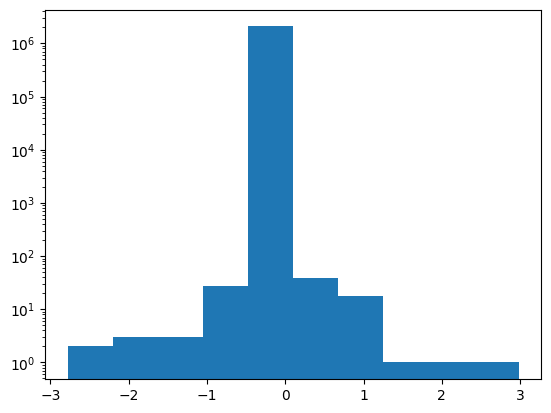

In [51]:
import matplotlib.pyplot as plt
plt.hist(val_transformed.mean(axis=1))
plt.yscale('log')
plt.show()

### Analyze dataset

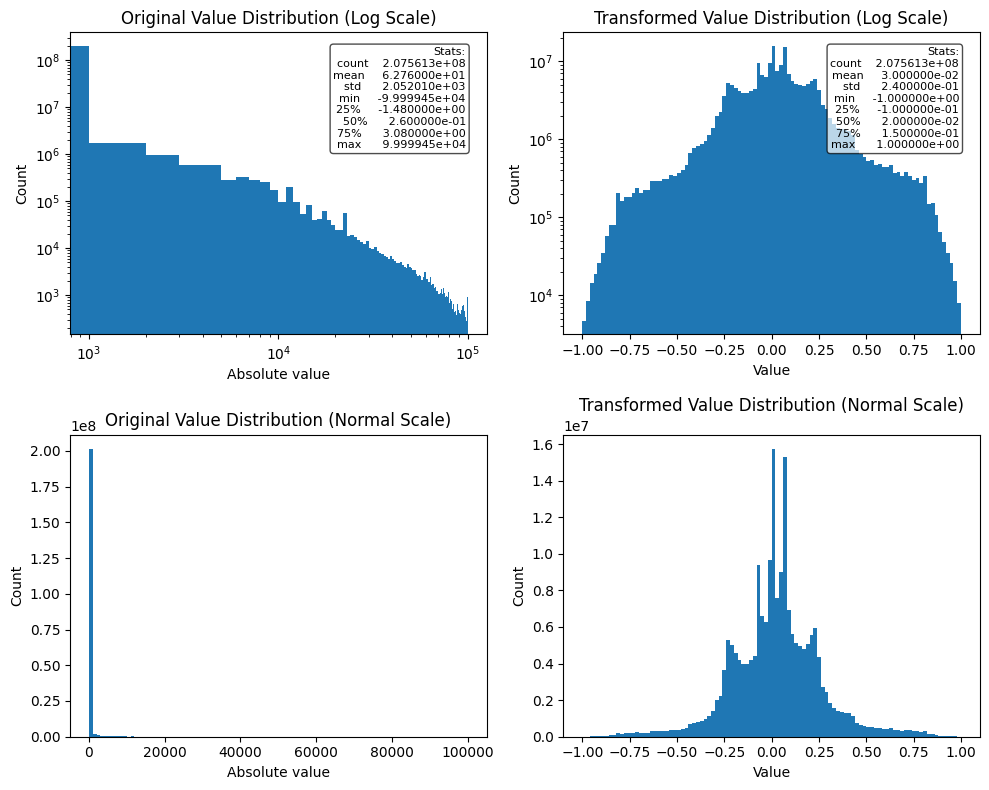

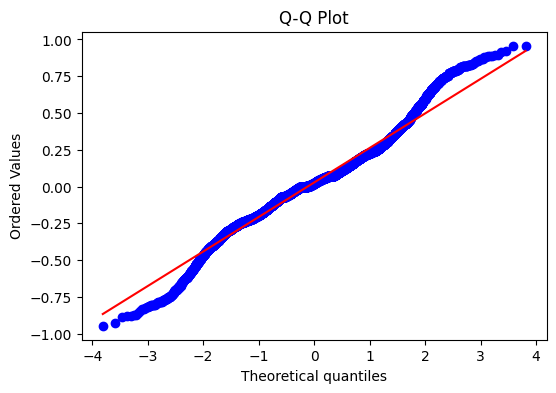

Number of outliers detected using z-score method: 3695765
Number of outliers detected using IQR method: 11302226


In [4]:
plot_value_distributions(values, val_transformed)
analyze_outliers(val_transformed)

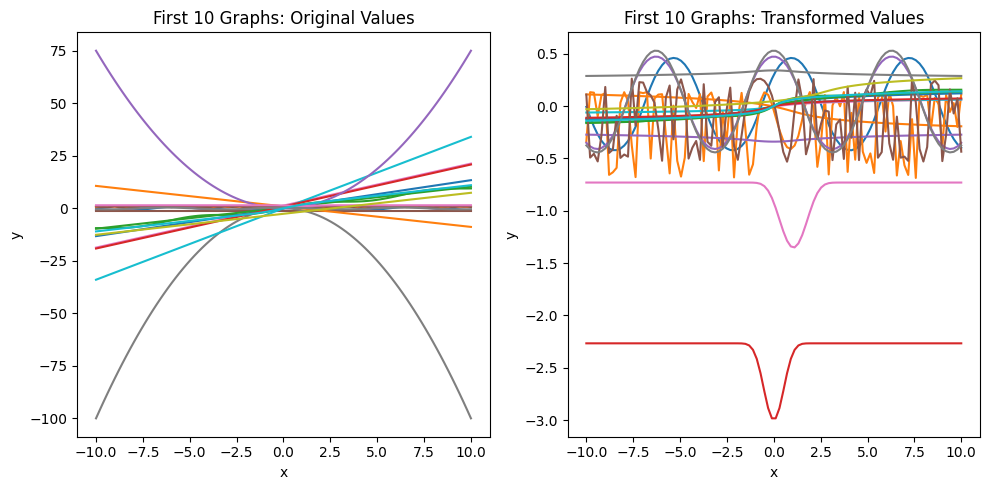

In [12]:
i = 10
plot_values(val_x, values, val_transformed, idx=np.arange(i, i+20))

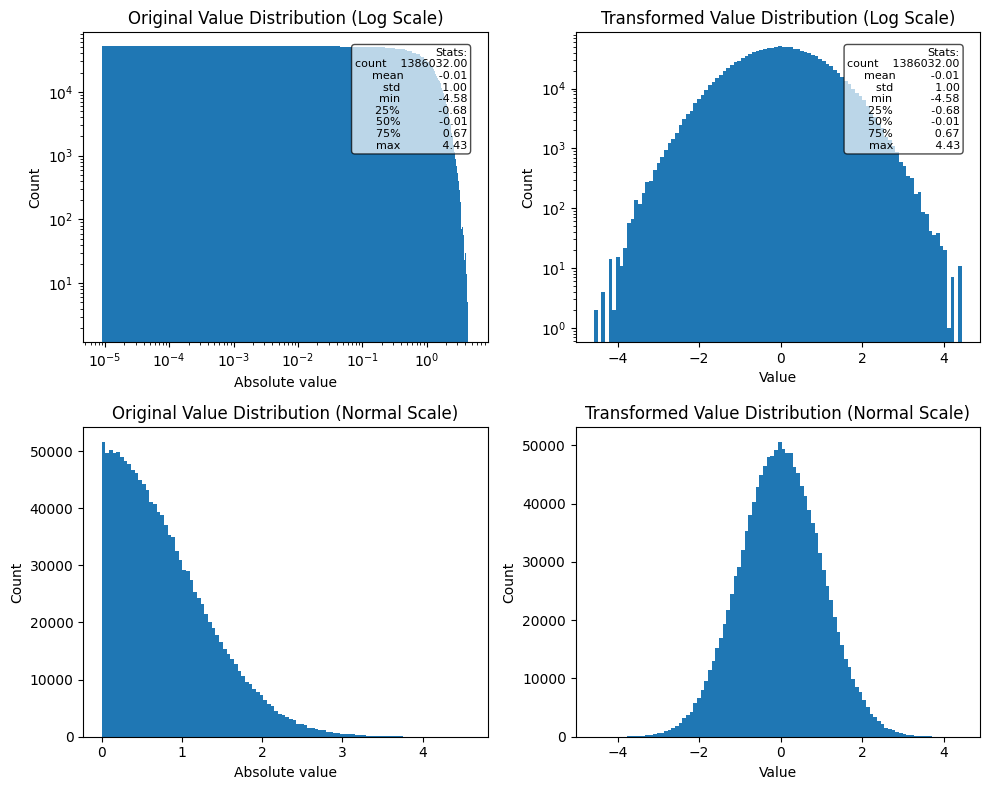

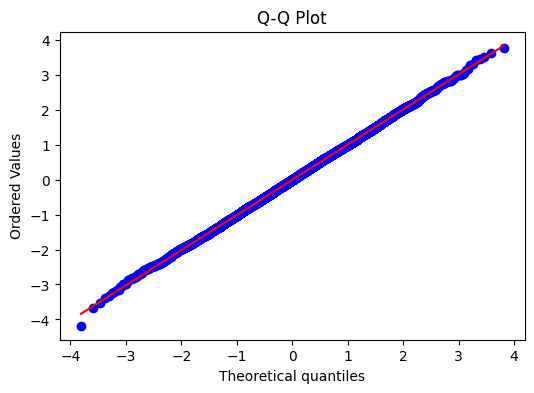

Number of outliers detected using z-score method: 3742
Number of outliers detected using IQR method: 9482


In [11]:
mask = (syntax[:, :, syntax_cats.index('CON')] == 1)
active_consts = consts[mask]

plot_value_distributions(active_consts, active_consts)
analyze_outliers(active_consts)

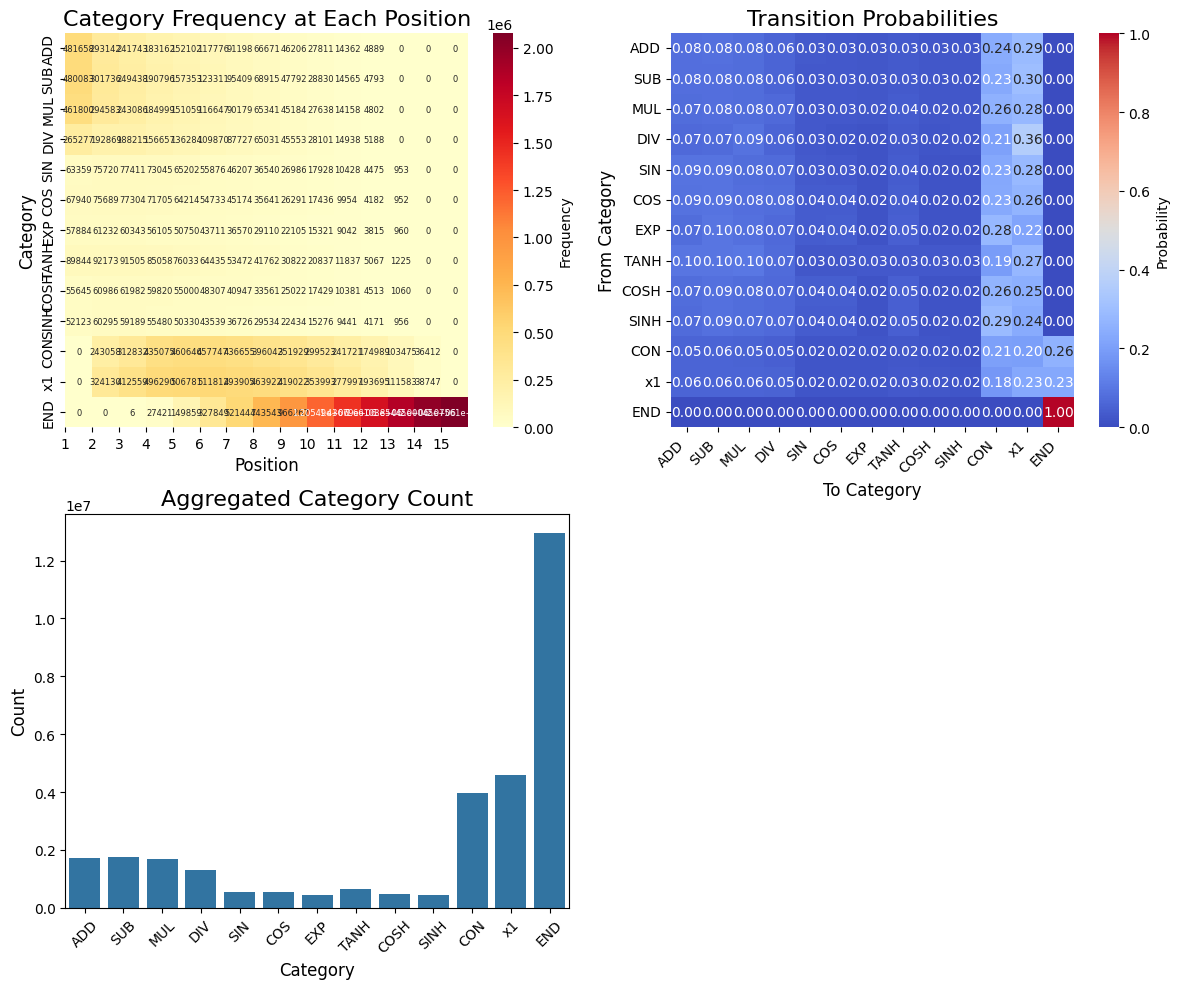

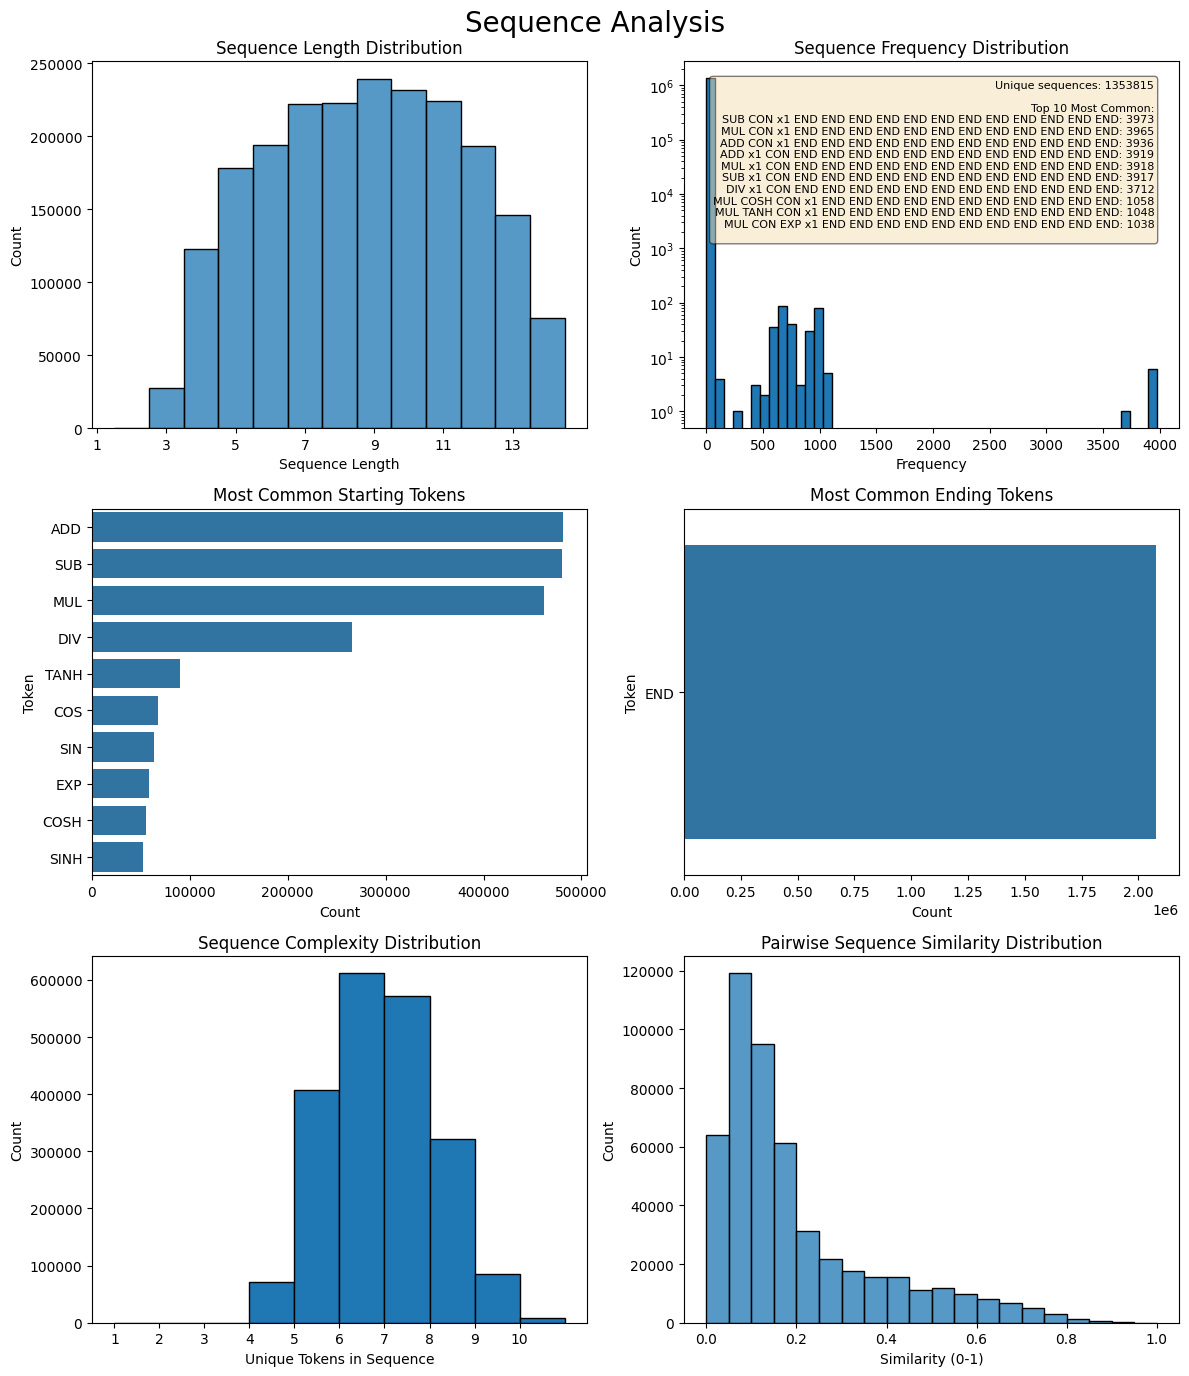

In [8]:
analyze_syntax_tokens(syntax, syntax_cats)
analyze_sequences(syntax, syntax_cats)

## Dev for new filter functions

Filters:
- Absolute value
- 1st derivative

In [14]:
from matplotlib import pyplot as plt

In [12]:
print(f"Values min: {values.min()}, max: {values.max()}")

# Calculate first derivative over each row
first_derivative = np.diff(values, axis=1)/np.diff(val_x, axis=0).T
print(f"First derivative min: {first_derivative.min()}, max: {first_derivative.max()}")

Values min: -99999.5, max: 99999.5
First derivative min: -369679.6875, max: 332179.34375


### Idea: Work with fourier components 
- large freq amplitudes -> 0
- Inspired by DL lectures

In [69]:
C_f

array([2.58551955e+04, 2.09603823e+02, 1.74372740e+04, 1.84029818e+03,
       1.31715839e+02, 2.02719247e+06, 0.00000000e+00, 3.09525017e+03,
       2.11226995e+06, 2.11226996e+06])

In [67]:
C_f = np.sum(np.abs(freqs * ft), axis=1)

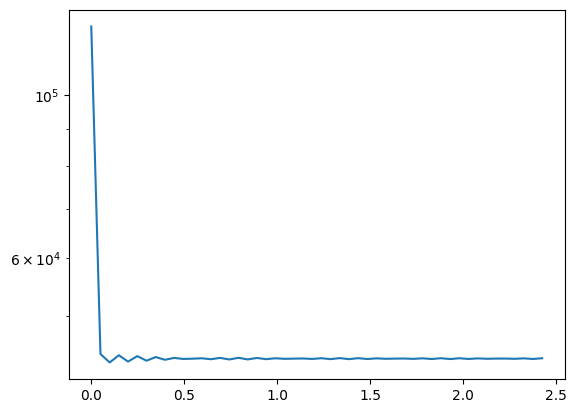

In [51]:
# FFT test
from matplotlib import pyplot as plt

a = values[:10, :]
ft = np.fft.fft(a, axis=1)
freqs = np.fft.fftfreq(a.shape[1], d=val_x[1]-val_x[0])

plt.plot(freqs[freqs>=0], np.abs(ft[0, freqs>=0])**2)
plt.yscale('log')
plt.show()


### Derivative filters

In [18]:
first_derivative = np.diff(val_transformed, axis=1) / np.diff(val_x, axis=0).T
second_derivative = np.diff(first_derivative, axis=1) / np.diff(val_x[:-1], axis=0).T
third_derivative = np.diff(second_derivative, axis=1) / np.diff(val_x[:-2], axis=0).T
fourth_derivative = np.diff(third_derivative, axis=1) / np.diff(val_x[:-3], axis=0).T
is_valid = (np.all(np.abs(first_derivative) < 1000, axis=1) & \
            np.all(np.abs(second_derivative) < 1000, axis=1) & \
            np.all(np.abs(third_derivative) < 1000, axis=1) & \
            np.all(np.abs(fourth_derivative) < 1000, axis=1))

In [29]:
is_valid.sum() / len(is_valid)

np.float64(1.0)

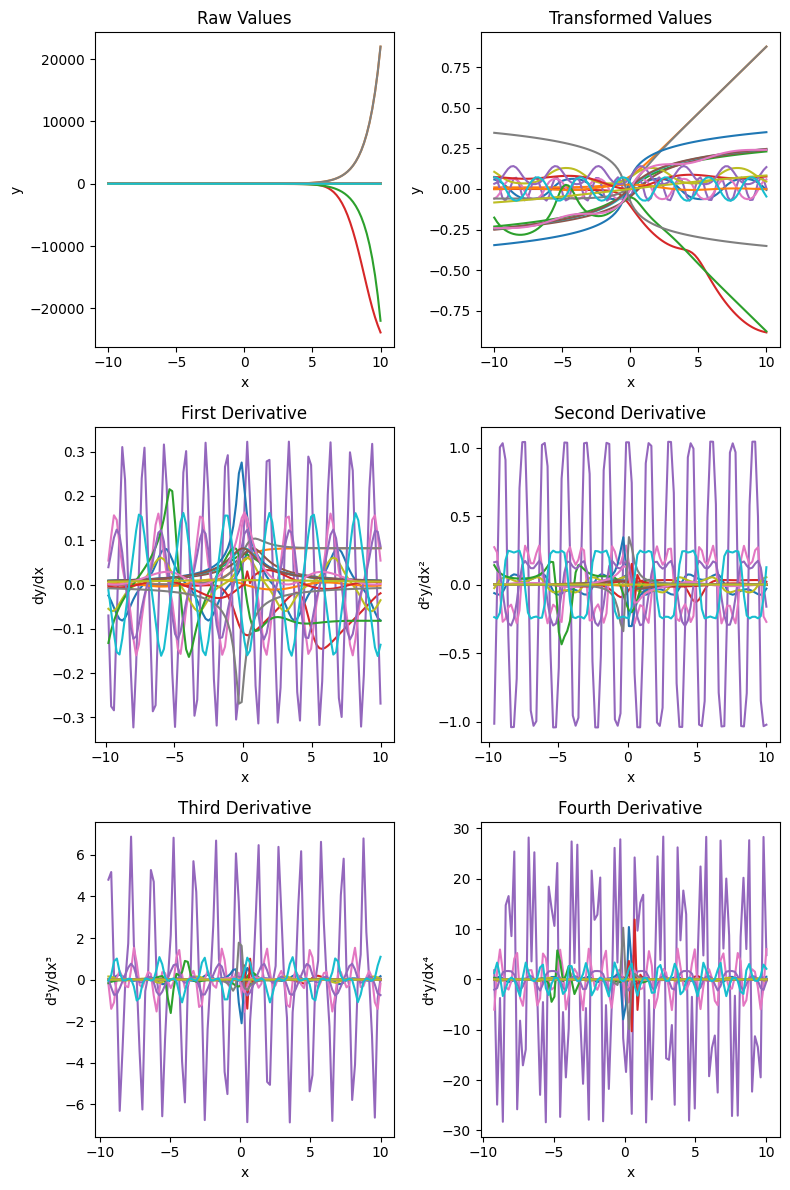

In [31]:
# Plot the ith function (raw values, transformed values, and derivatives)
i, n = 120, 20  # Using the same index as in the previous example

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(8, 12))

# Plot raw values
ax1.plot(val_x, values[i:i+n, :].T)
ax1.set_title('Raw Values')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

# Plot transformed values
ax2.plot(val_x, val_transformed[i:i+n, :].T)
ax2.set_title('Transformed Values')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

# Plot first derivative
ax3.plot(val_x[1:], first_derivative[i:i+n, :].T)
ax3.set_title('First Derivative')
ax3.set_xlabel('x')
ax3.set_ylabel('dy/dx')

# Plot second derivative
ax4.plot(val_x[2:], second_derivative[i:i+n, :].T)
ax4.set_title('Second Derivative')
ax4.set_xlabel('x')
ax4.set_ylabel('d²y/dx²')

# Plot third derivative
ax5.plot(val_x[3:], third_derivative[i:i+n, :].T)
ax5.set_title('Third Derivative')
ax5.set_xlabel('x')
ax5.set_ylabel('d³y/dx³')

# Plot fourth derivative
ax6.plot(val_x[4:], fourth_derivative[i:i+n, :].T)
ax6.set_title('Fourth Derivative')
ax6.set_xlabel('x')
ax6.set_ylabel('d⁴y/dx⁴')

plt.tight_layout()
plt.show()

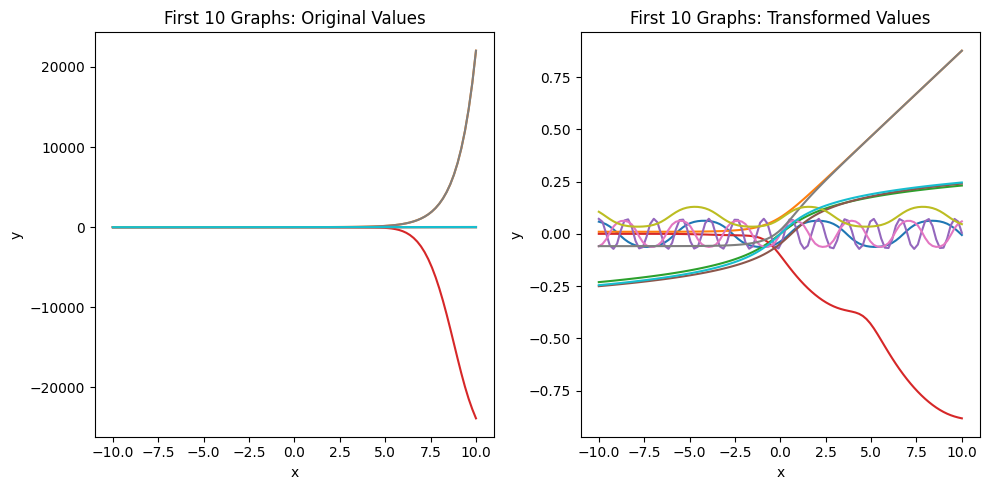

In [27]:
i = 120
plot_values(val_x, values, val_transformed, idx=np.arange(i, i+10))